In [1]:
import os
import numpy as np
from phathom import io
from phathom.segmentation import graphcuts
from phathom.preprocess import filtering
from phathom import plotting
import matplotlib.pyplot as plt
from skimage import morphology

In [2]:
import warnings
# warnings.filterwarnings('error', append=True)  # For RuntimeWarnings caught in graphcuts

In [3]:
%matplotlib notebook

In [4]:
working_dir = '/media/jswaney/Drive/Justin/organoid_etango/'

# Foreground mask graph cuts

In [5]:
syto16_path = 'syto16_test2.zarr'

syto16 = io.zarr.open(os.path.join(working_dir, syto16_path))
syto16.shape, syto16.dtype

((256, 512, 512), dtype('uint16'))

In [6]:
syto16_smooth_path = 'syto16_test2_smooth.zarr'

syto16_smooth = io.zarr.new_zarr_like(os.path.join(working_dir, syto16_smooth_path), syto16)
syto16.shape, syto16.dtype

((256, 512, 512), dtype('uint16'))

In [7]:
sigma = (0.7, 1.5, 1.5)
chunks = (128, 128, 128)
overlap = 8
nb_workers = None

filtering.gaussian_blur_parallel(syto16, sigma, syto16_smooth, chunks, overlap, nb_workers)

100%|██████████| 32/32 [00:01<00:00, 19.72it/s]


In [8]:
foreground_path = 'foreground.zarr'

foreground = io.zarr.new_zarr(os.path.join(working_dir, foreground_path), 
                              syto16.shape, 
                              syto16.chunks, 
                              np.uint8)

In [9]:
overlap = 8
chunks = (128, 128, 128)
nb_workers = 12
kwargs = {'back_mu': 500,
          'obj_mu': 2200,
          'w_const': 20}

graphcuts.parallel_graph_cuts(syto16_smooth, foreground, overlap, chunks, nb_workers, **kwargs)

  0%|          | 0/32 [00:00<?, ?it/s]/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/phathom/phathom/segmentation/graphcuts.py:115: RuntimeWarning: divide by zero encountered in log
  penalty = -np.log(px)
/home/jswaney/pha

<IPython.core.display.Javascript object>


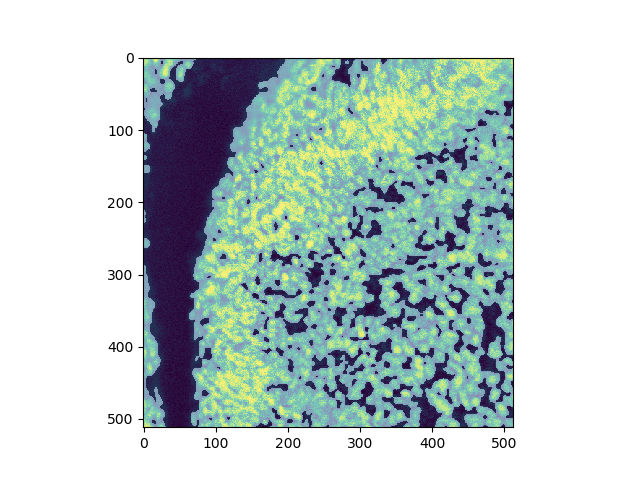

In [10]:
plt.imshow(syto16[8])
plt.imshow(foreground[8], alpha=0.4, cmap='gray')
plt.show()

In [11]:
prob_path = 'nuclei_probability.zarr'

prob = io.zarr.open(os.path.join(working_dir, prob_path))
prob.shape

(256, 512, 512)

In [14]:
centers_path = 'centers.npy'

centers = np.load(os.path.join(working_dir, centers_path))
centers.shape

(39459, 3)

<IPython.core.display.Javascript object>


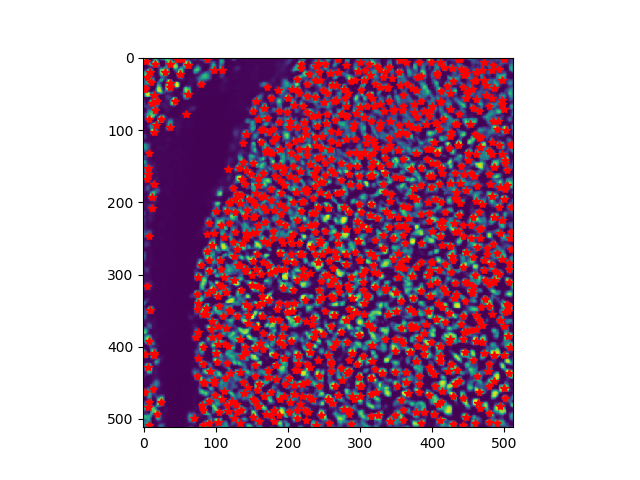

In [13]:
plotting.zprojection(prob, centers, zlim=[10, 18])

In [12]:
from phathom.segmentation import segmentation

In [13]:
segmentation_path = 'segmentation.zarr'

seg = io.zarr.new_zarr(os.path.join(working_dir, segmentation_path), 
                       syto16.shape, 
                       syto16.chunks, 
                       np.uint8)

In [15]:
chunks = (128, 128, 128)
overlap = 16
nb_workers = 4

segmentation.watershed_centers_parallel(prob, centers, foreground, seg, chunks, overlap, nb_workers)

  0%|          | 0/32 [00:00<?, ?it/s]/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
  3%|▎         | 1/32 [00:08<04:28,  8.67s/it]/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)
/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/s

In [18]:
from scipy.ndimage import label

In [19]:
labels, nb_lbls = label(seg[:])
print(nb_lbls)

86672


In [20]:
print(centers.shape)

(39459, 3)


In [21]:
import tifffile
tifffile.imsave(os.path.join(working_dir, 'pseg.tif'), labels.astype(np.float32))

In [11]:
from phathom.synthetic import points_to_binary

In [16]:
image = -prob[:]
markers = label(points_to_binary(tuple(centers.T), image.shape, cval=1))[0]
mask = foreground[:]

seg = morphology.watershed(image, markers, mask=mask, watershed_line=True)

/home/jswaney/anaconda3/envs/phathom/lib/python3.6/site-packages/skimage/util/arraycrop.py:175: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = np.array(ar[slices], order=order, copy=True)


In [17]:
seg.shape

(256, 512, 512)

In [16]:
import matplotlib
cmap = matplotlib.colors.ListedColormap(np.vstack((np.zeros((1, 3)), np.random.rand(centers.shape[0]-1, 3))))

<IPython.core.display.Javascript object>


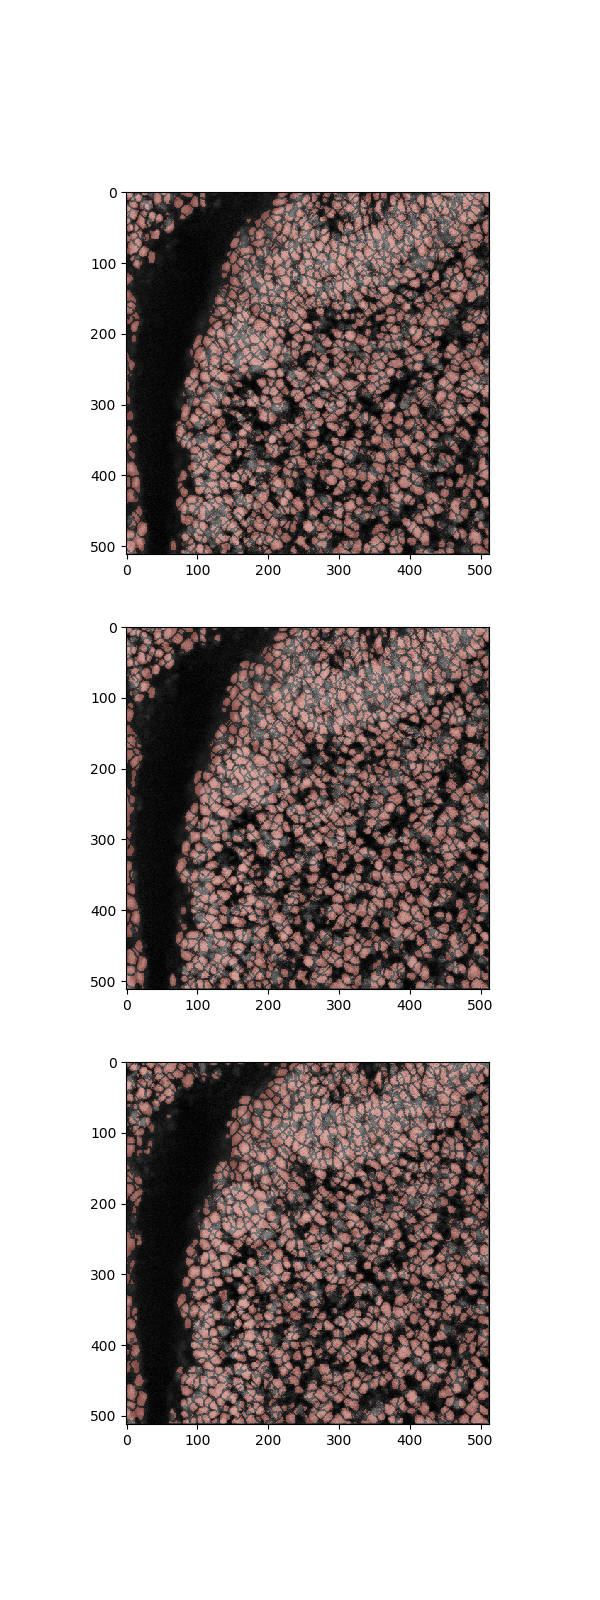

In [17]:
plt.figure(figsize=(6, 16))
plt.subplot(311)
plt.imshow(syto16[16], cmap='gray')
plt.imshow(seg[16], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.subplot(312)
plt.imshow(syto16[18], cmap='gray')
plt.imshow(seg[18], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.subplot(313)
plt.imshow(syto16[20], cmap='gray')
plt.imshow(seg[20], cmap=cmap, clim=[0, centers.shape[0]], alpha=0.5)
plt.show()

In [35]:
import tifffile

In [37]:
tifffile.imsave(os.path.join(working_dir, 'syto16_test.tif'), syto16[:].astype(np.float32))
tifffile.imsave(os.path.join(working_dir, 'seg.tif'), seg.astype(np.float32))